In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import time

import PulseFinderScipy as pf
import PulseQuantities as pq
import PulseClassification as pc

In [2]:
data_dir = "G:/.shortcut-targets-by-id/11qeqHWCbcKfFYFQgvytKem8rulQCTpj8/crystalize/data/data-202105/20210503/20210503_1920_Po_0g_0c_0.75bar_3mv_circ_20min/"
data_dir_1 = "G:/.shortcut-targets-by-id/11qeqHWCbcKfFYFQgvytKem8rulQCTpj8/crystalize/data/data-202105/20210504/20210504_1430_Po_0g_0c_0.72bar_3mv_circ_20min/"
data_dir_2 = "G:/.shortcut-targets-by-id/11qeqHWCbcKfFYFQgvytKem8rulQCTpj8/crystalize/data/data-202104/040221/Po_0g_0c_1.2bar_circ_20min_1019/"
save_dir = "C:/Users/maque/OneDrive/work/Sxe/SXe LXe/"

In [3]:
# set plotting style
mpl.rcParams['font.size']=22
mpl.rcParams['legend.fontsize']='small'
mpl.rcParams['figure.autolayout']=True
mpl.rcParams['figure.figsize']=[8.0,6.0]

# use for coloring pulses
pulse_class_colors = np.array(['blue', 'green', 'red', 'magenta', 'darkorange'])
pulse_class_labels = np.array(['Other', 'S1-like LXe', 'S1-like gas', 'S2-like', 'Merged S1/S2'])
pc_legend_handles=[]
for class_ind in range(len(pulse_class_labels)):
    pc_legend_handles.append(mpl.patches.Patch(color=pulse_class_colors[class_ind], label=str(class_ind)+": "+pulse_class_labels[class_ind]))

# ==================================================================
# define DAQ and other parameters
#wsize = 12500             # size of event window in samples. 1 sample = 2 ns.
event_window = 25.  # in us
wsize = int(500 * event_window)  # samples per waveform # 12500 for 25 us
vscale = (2000.0/16384.0) # = 0.122 mV/ADCC, vertical scale
tscale = (8.0/4096.0)     # = 0.002 µs/sample, time scale

post_trigger = 0.5 # Was 0.2 for data before 11/22/19
trigger_time_us = event_window*(1-post_trigger)
trigger_time = int(trigger_time_us/tscale)

n_sipms = 8
n_channels = n_sipms+1 # includes sum

# define top, bottom channels
n_top = int((n_channels-1)/2)
top_channels=np.array(range(n_top),int)
bottom_channels=np.array(range(n_top,2*n_top),int)


In [4]:
listrq = np.load(data_dir+'rq.npz')

n_events = listrq['n_events'][()]
n_pulses = listrq['n_pulses']
n_s1 = listrq['n_s1']
n_s2 = listrq['n_s2']
s1_before_s2 = listrq['s1_before_s2']
p_area = listrq['p_area']
p_class = listrq['p_class']
drift_Time = listrq['drift_Time']
p_max_height = listrq['p_max_height']
p_min_height = listrq['p_min_height']
p_width = listrq['p_width']
p_afs_2l = listrq['p_afs_2l']
p_afs_50 = listrq['p_afs_50']
p_area_ch = listrq['p_area_ch']
p_area_ch_frac = listrq['p_area_ch_frac']
p_area_top = listrq['p_area_top']
p_area_bottom = listrq['p_area_bottom']
p_tba = listrq['p_tba']
sum_s1_area = listrq['sum_s1_area']
sum_s2_area = listrq['sum_s2_area']

center_top_x = listrq['center_top_x']
center_top_y = listrq['center_top_y']
center_bot_x = listrq['center_bot_x']
center_bot_y = listrq['center_bot_y']

listrq.close()

In [5]:
listrq_1 = np.load(data_dir_1+'rq.npz')

n_events_1 = listrq_1['n_events'][()]
n_pulses_1 = listrq_1['n_pulses']
n_s1_1 = listrq_1['n_s1']
n_s2_1 = listrq_1['n_s2']
s1_before_s2_1 = listrq_1['s1_before_s2']
p_area_1 = listrq_1['p_area']
p_class_1 = listrq_1['p_class']
drift_Time_1 = listrq_1['drift_Time']
p_max_height_1 = listrq_1['p_max_height']
p_min_height_1 = listrq_1['p_min_height']
p_width_1 = listrq_1['p_width']
p_afs_2l_1 = listrq_1['p_afs_2l']
p_afs_50_1 = listrq_1['p_afs_50']
p_area_ch_1 = listrq_1['p_area_ch']
p_area_ch_frac_1 = listrq_1['p_area_ch_frac']
p_area_top_1 = listrq_1['p_area_top']
p_area_bottom_1 = listrq_1['p_area_bottom']
p_tba_1 = listrq_1['p_tba']
sum_s1_area_1 = listrq_1['sum_s1_area']
sum_s2_area_1 = listrq_1['sum_s2_area']

center_top_x_1 = listrq_1['center_top_x']
center_top_y_1 = listrq_1['center_top_y']
center_bot_x_1 = listrq_1['center_bot_x']
center_bot_y_1 = listrq_1['center_bot_y']

listrq_1.close()

In [12]:
listrq_2 = np.load(data_dir_2+'rq.npz')

n_events_2 = listrq_2['n_events'][()]
n_pulses_2 = listrq_2['n_pulses']
n_s1_2 = listrq_2['n_s1']
n_s2_2 = listrq_2['n_s2']
s1_before_s2_2 = listrq_2['s1_before_s2']
p_area_2 = listrq_2['p_area']
p_class_2 = listrq_2['p_class']
drift_Time_2 = listrq_2['drift_Time']
p_max_height_2 = listrq_2['p_max_height']
p_min_height_2 = listrq_2['p_min_height']
p_width_2 = listrq_2['p_width']
p_afs_2l_2 = listrq_2['p_afs_2l']
p_afs_50_2 = listrq_2['p_afs_50']
p_area_ch_2 = listrq_2['p_area_ch']
p_area_ch_frac_2 = listrq_2['p_area_ch_frac']
p_area_top_2 = listrq_2['p_area_top']
p_area_bottom_2 = listrq_2['p_area_bottom']
p_tba_2 = listrq_2['p_tba']
sum_s1_area_2 = listrq_2['sum_s1_area']
sum_s2_area_2 = listrq_2['sum_s2_area']

center_top_x_2 = listrq_2['center_top_x']
center_top_y_2 = listrq_2['center_top_y']
center_bot_x_2 = listrq_2['center_bot_x']
center_bot_y_2 = listrq_2['center_bot_y']

listrq_2.close()

In [6]:
p_cut_name = "Po_all"

In [7]:
n_golden = int(np.sum(drift_Time>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden,n_golden*100./n_events))

p_t_rise = tscale*(p_afs_50-p_afs_2l)
b_up_down = -0.76
# Define some standard cuts for plotting
cut_dict = {}
cut_dict['ValidPulse'] = p_area > 0
cut_dict['PulseClass0'] = p_class == 0
cut_dict['S1'] = (p_class == 1) + (p_class == 2)
cut_dict['S2'] = (p_class == 3) + (p_class == 4)
cut_dict['Co_peak'] = (p_area>30)*(p_area<60)
cut_dict['Po_down'] = (p_area>10000)*(p_area<25000)*(p_tba>-1.)*(p_tba<b_up_down)
cut_dict['Po_up'] = (p_area>10000)*(p_area<25000)*(p_tba>b_up_down)*(p_tba<-.15)
cut_dict['Po_all'] = (p_area>7000)*(p_area<25000)*(p_tba<-.75)
SS_cut = drift_Time > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=False # One entry per pulse
save_S1S2_plots=False # One entry per S1 (S2) pulse
save_event_plots=False # One entry per event
pulse_cut_name = p_cut_name#'Co_peak'
pulse_cut = cut_dict[pulse_cut_name]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut),np.sum(pulse_cut)*100./np.size(p_area)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

s1_cut = pulse_cut*cut_dict['S1']
cleanS1Area = p_area[s1_cut].flatten()
cleanS1RiseTime = p_t_rise[s1_cut].flatten()
cleanS1AreaChFrac = p_area_ch_frac[s1_cut]
cleanS1TBA = p_tba[s1_cut].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut),np.sum(s1_cut)*100./np.size(p_area)))

s2_cut = pulse_cut*cut_dict['S2']
cleanS2Area = p_area[s2_cut].flatten()
cleanS2RiseTime = p_t_rise[s2_cut].flatten()
cleanS2AreaChFrac = p_area_ch_frac[s2_cut]
cleanS2TBA = p_tba[s2_cut].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut),np.sum(s2_cut)*100./np.size(p_area)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany = n_pulses < 1000 # How many pulses you do want
nArea = p_area[howMany,:]
nMax = p_max_height[howMany,:]
nmin = p_min_height[howMany,:]
nWidth = p_width[howMany,:]

na2l = p_afs_2l[howMany]
na50 = p_afs_50[howMany]


# Event level quantities 
event_cut_dict = {}
event_cut_dict["SS"] = drift_Time > 0 
event_cut_dict["MS"] = (n_s1 == 1)*(n_s2 > 1)*s1_before_s2
event_cut_dict["Po"] = (drift_Time>0)*np.any((p_tba<-0.25)*(p_tba>-0.72)*(p_area>1400)*(p_area<3200), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict["lg_S1"] = (drift_Time>0)*np.any((p_area>1000.)*cut_dict["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict["ht"] = (drift_Time>0)*np.any(p_max_height>50, axis=1)
event_cut_dict["area"] = (sum_s1_area>10**3.0)*(sum_s1_area<10**3.5)*(sum_s2_area<10**5.1)*(sum_s2_area>10**4.6)
event_cut_dict["orange"] = np.any((p_tba<-0.3)*(p_tba>-0.75)*(p_t_rise>0.6)*(p_t_rise<1.7), axis=1)
event_cut_dict["Po_left"] = np.any((p_tba<-0.76)*(p_tba>-1.)*(p_area>2000)*(p_area<3000), axis=1)
event_cut_dict['Po_all'] = (drift_Time>0)*np.any((p_area>7000)*(p_area<25000)*(p_tba<-.25), axis=1)*(p_area[:,1]>100)

event_cut_name = "Po_all"#"lg_S1"
event_cut = event_cut_dict[event_cut_name] 
cleanSumS1 = sum_s1_area[event_cut]
cleanSumS2 = sum_s2_area[event_cut]
cleanDT = drift_Time[event_cut]

four_drift_time = np.transpose([drift_Time, drift_Time,drift_Time,drift_Time])
clean_drift_time_four = four_drift_time[event_cut]
clean_center_top_x = center_top_x[event_cut]
clean_center_top_y = center_top_y[event_cut]
clean_center_bot_x = center_bot_x[event_cut]
clean_center_bot_y = center_bot_y[event_cut]

cleanArea = p_area[pulse_cut]
cleanMax = p_max_height[pulse_cut]
cleanMin = p_min_height[pulse_cut]
cleanWidth = p_width[pulse_cut]
cleanPulseClass = p_class[pulse_cut]

cleanAFS2l = p_afs_2l[pulse_cut]
cleanAFS50 = p_afs_50[pulse_cut]
cleanRiseTime = p_t_rise[pulse_cut]

cleanAreaCh = p_area_ch[pulse_cut] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac = p_area_ch_frac[pulse_cut]
cleanAreaTop = p_area_top[pulse_cut]
cleanAreaBottom = p_area_bottom[pulse_cut]
cleanTBA = p_tba[pulse_cut]
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

print("number of events found passing cut "+event_cut_name+" = {0:d} ({1:g}%)".format(np.sum(event_cut),np.sum(event_cut)*100./n_events))


number of golden events found = 20 (0.0461574%)
number of pulses found passing cut Po_all = 3818 (2.20286% of pulses found)
number of S1 pulses found = 3814 (2.20055% of pulses found)
number of S2 pulses found = 4 (0.00230787% of pulses found)
number of events found passing cut Po_all = 1 (0.00230787%)


In [8]:
n_golden_1 = int(np.sum(drift_Time_1>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden_1,n_golden_1*100./n_events_1))

p_t_rise_1 = tscale*(p_afs_50_1-p_afs_2l_1)
test_b = -0.76
# Define some standard cuts for plotting
cut_dict_1 = {}
cut_dict_1['ValidPulse'] = p_area_1 > 0
cut_dict_1['PulseClass0'] = p_class_1 == 0
cut_dict_1['S1'] = (p_class_1 == 1) + (p_class_1 == 2)
cut_dict_1['S2'] = (p_class_1 == 3) + (p_class_1 == 4)
cut_dict_1['Co_peak'] = (p_area_1>30)*(p_area_1<60)
cut_dict_1['Po_down'] = (p_area_1>10000)*(p_area_1<25000)*(p_tba_1>-1.)*(p_tba_1<test_b)
cut_dict_1['Po_up'] = (p_area_1>10000)*(p_area_1<25000)*(p_tba_1>test_b)*(p_tba_1<-.15)
cut_dict_1['Po_all'] = (p_area_1>7000)*(p_area_1<25000)*(p_tba_1<-.55)
SS_cut_1 = drift_Time_1 > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=False # One entry per pulse
save_S1S2_plots=False # One entry per S1 (S2) pulse
save_event_plots=False # One entry per event
pulse_cut_name_1 = p_cut_name#'Co_peak'
pulse_cut_1 = cut_dict_1[pulse_cut_name_1]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut_1),np.sum(pulse_cut_1)*100./np.size(p_area_1)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

s1_cut_1 = pulse_cut_1*cut_dict_1['S1']
cleanS1Area_1 = p_area_1[s1_cut_1].flatten()
cleanS1RiseTime_1 = p_t_rise_1[s1_cut_1].flatten()
cleanS1AreaChFrac_1 = p_area_ch_frac_1[s1_cut_1]
cleanS1TBA_1 = p_tba_1[s1_cut_1].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut_1),np.sum(s1_cut_1)*100./np.size(p_area_1)))

s2_cut_1 = pulse_cut_1*cut_dict_1['S2']
cleanS2Area_1 = p_area_1[s2_cut_1].flatten()
cleanS2RiseTime_1 = p_t_rise_1[s2_cut_1].flatten()
cleanS2AreaChFrac_1 = p_area_ch_frac_1[s2_cut_1]
cleanS2TBA_1 = p_tba_1[s2_cut_1].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut_1),np.sum(s2_cut_1)*100./np.size(p_area_1)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany_1 = n_pulses_1 < 1000 # How many pulses you do want
nArea_1 = p_area_1[howMany_1,:]
nMax_1 = p_max_height_1[howMany_1,:]
nmin_1 = p_min_height_1[howMany_1,:]
nWidth_1 = p_width_1[howMany_1,:]

na2l_1 = p_afs_2l_1[howMany_1]
na50_1 = p_afs_50_1[howMany_1]


# Event level quantities 
event_cut_dict_1 = {}
event_cut_dict_1["SS"] = drift_Time_1 > 0 
event_cut_dict_1["MS"] = (n_s1_1 == 1)*(n_s2_1 > 1)*s1_before_s2_1
event_cut_dict_1["Po"] = (drift_Time_1>0)*np.any((p_tba_1<-0.25)*(p_tba_1>-0.72)*(p_area_1>1400)*(p_area_1<3200), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict_1["lg_S1"] = (drift_Time_1>0)*np.any((p_area_1>1000.)*cut_dict_1["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict_1["ht"] = (drift_Time_1>0)*np.any(p_max_height_1>50, axis=1)
event_cut_dict_1["area"] = (sum_s1_area_1>10**3.0)*(sum_s1_area_1<10**3.5)*(sum_s2_area_1<10**5.1)*(sum_s2_area_1>10**4.6)
event_cut_dict_1["orange"] = np.any((p_tba_1<-0.3)*(p_tba_1>-0.75)*(p_t_rise_1>0.6)*(p_t_rise_1<1.7), axis=1)
event_cut_dict_1["Po_left"] = np.any((p_tba_1<-0.76)*(p_tba_1>-1.)*(p_area_1>2000)*(p_area_1<3000), axis=1)
event_cut_dict_1['Po_all'] = (drift_Time_1>0)*np.any((p_area_1>8000)*(p_area_1<25000)*(p_tba_1<-.25), axis=1)*(p_area_1[:,1]>100)

event_cut_name_1 = "Po_all"#"lg_S1"
event_cut_1 = event_cut_dict_1[event_cut_name] 
cleanSumS1_1 = sum_s1_area_1[event_cut_1]
cleanSumS2_1 = sum_s2_area_1[event_cut_1]
cleanDT_1 = drift_Time_1[event_cut_1]

four_drift_time_1 = np.transpose([drift_Time_1, drift_Time_1,drift_Time_1,drift_Time_1])
clean_drift_time_four_1 = four_drift_time_1[event_cut_1]
clean_center_top_x_1 = center_top_x_1[event_cut_1]
clean_center_top_y_1 = center_top_y_1[event_cut_1]
clean_center_bot_x_1 = center_bot_x_1[event_cut_1]
clean_center_bot_y_1 = center_bot_y_1[event_cut_1]

cleanArea_1 = p_area_1[pulse_cut_1]
cleanMax_1 = p_max_height_1[pulse_cut_1]
cleanMin_1 = p_min_height_1[pulse_cut_1]
cleanWidth_1 = p_width_1[pulse_cut_1]
cleanPulseClass_1 = p_class_1[pulse_cut_1]

cleanAFS2l_1 = p_afs_2l_1[pulse_cut_1]
cleanAFS50_1 = p_afs_50_1[pulse_cut_1]
cleanRiseTime_1 = p_t_rise_1[pulse_cut_1]

cleanAreaCh_1 = p_area_ch_1[pulse_cut_1] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac_1 = p_area_ch_frac_1[pulse_cut_1]
cleanAreaTop_1 = p_area_top_1[pulse_cut_1]
cleanAreaBottom_1 = p_area_bottom_1[pulse_cut_1]
cleanTBA_1 = p_tba_1[pulse_cut_1]
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

print("number of events found passing cut "+event_cut_name_1+" = {0:d} ({1:g}%)".format(np.sum(event_cut_1),np.sum(event_cut_1)*100./n_events_1))


number of golden events found = 109 (0.291241%)
number of pulses found passing cut Po_all = 3776 (2.52231% of pulses found)
number of S1 pulses found = 3762 (2.51296% of pulses found)
number of S2 pulses found = 14 (0.00935179% of pulses found)
number of events found passing cut Po_all = 11 (0.0293913%)


In [27]:
n_golden_2 = int(np.sum(drift_Time_2>0))
print("number of golden events found = {0:d} ({1:g}%)".format(n_golden_2,n_golden_2*100./n_events_2))

p_t_rise_2 = tscale*(p_afs_50_2-p_afs_2l_2)
test_b = -0.75
# Define some standard cuts for plotting
cut_dict_2 = {}
cut_dict_2['ValidPulse'] = p_area_2 > 0
cut_dict_2['PulseClass0'] = p_class_2 == 0
cut_dict_2['S1'] = (p_class_2 == 1) + (p_class_2 == 2)
cut_dict_2['S2'] = (p_class_2 == 3) + (p_class_2 == 4)
cut_dict_2['Co_peak'] = (p_area_2>30)*(p_area_2<60)
cut_dict_2['Po_down'] = (p_area_2>1500)*(p_area_2<5000)*(p_tba_2>-1.)*(p_tba_2<test_b)
cut_dict_2['Po_up'] = (p_area_2>1500)*(p_area_2<5000)*(p_tba_2>test_b)*(p_tba_2<-.15)
cut_dict_2['Po_all'] = (p_area_2>1500)*(p_area_2<5000)*(p_tba_2<-.55)
SS_cut_2 = drift_Time_2 > 0

# Pick which cut from cut_dict to apply here and whether to save plots
save_pulse_plots=False # One entry per pulse
save_S1S2_plots=False # One entry per S1 (S2) pulse
save_event_plots=False # One entry per event
pulse_cut_name_2 = p_cut_name#'Co_peak'
pulse_cut_2 = cut_dict_2[pulse_cut_name_2]
print("number of pulses found passing cut "+pulse_cut_name+" = {0:d} ({1:g}% of pulses found)".format(np.sum(pulse_cut_2),np.sum(pulse_cut_2)*100./np.size(p_area_2)))
#pulse_cut_name = 'ValidPulse_SS_Evt'
#pulse_cut = pulse_cut*SS_cut[:,np.newaxis] # add second dimension to allow broadcasting

s1_cut_2 = pulse_cut_2*cut_dict_2['S1']
cleanS1Area_2 = p_area_2[s1_cut_2].flatten()
cleanS1RiseTime_2 = p_t_rise_2[s1_cut_2].flatten()
cleanS1AreaChFrac_2 = p_area_ch_frac_2[s1_cut_2]
cleanS1TBA_2 = p_tba_2[s1_cut_2].flatten()
print("number of S1 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s1_cut_2),np.sum(s1_cut_2)*100./np.size(p_area_2)))

s2_cut_2 = pulse_cut_2*cut_dict_2['S2']
cleanS2Area_2 = p_area_2[s2_cut_2].flatten()
cleanS2RiseTime_2 = p_t_rise_2[s2_cut_2].flatten()
cleanS2AreaChFrac_2 = p_area_ch_frac_2[s2_cut_2]
cleanS2TBA_2 = p_tba_2[s2_cut_2].flatten()
print("number of S2 pulses found = {0:d} ({1:g}% of pulses found)".format(np.sum(s2_cut_2),np.sum(s2_cut_2)*100./np.size(p_area_2)))

# Quantities for plotting only events with n number of pulses, not just all of them
# May still contain empty pulses
howMany_2 = n_pulses_2 < 1000 # How many pulses you do want
nArea_2 = p_area_2[howMany_2,:]
nMax_2 = p_max_height_2[howMany_2,:]
nmin_2 = p_min_height_2[howMany_2,:]
nWidth_2 = p_width_2[howMany_2,:]

na2l_2 = p_afs_2l_2[howMany_2]
na50_2 = p_afs_50_2[howMany_2]


# Event level quantities 
event_cut_dict_2 = {}
event_cut_dict_2["SS"] = drift_Time_2 > 0 
event_cut_dict_2["MS"] = (n_s1_2 == 1)*(n_s2_2 > 1)*s1_before_s2_2
event_cut_dict_2["Po"] = (drift_Time_2>0)*np.any((p_tba_2<-0.25)*(p_tba_2>-0.72)*(p_area_2>1400)*(p_area_2<3200), axis=1)#np.any((p_tba<-0.85)*(p_tba>-0.91)*(p_area>1500)*(p_area<2700), axis=1) # true if any pulse in event matches these criteria
event_cut_dict_2["lg_S1"] = (drift_Time_2>0)*np.any((p_area_2>1000.)*cut_dict_2["S1"], axis=1) # true if any S1 has area>1000
event_cut_dict_2["ht"] = (drift_Time_2>0)*np.any(p_max_height_2>50, axis=1)
event_cut_dict_2["area"] = (sum_s1_area_2>10**3.0)*(sum_s1_area_2<10**3.5)*(sum_s2_area_2<10**5.1)*(sum_s2_area_2>10**4.6)
event_cut_dict_2["orange"] = np.any((p_tba_2<-0.3)*(p_tba_2>-0.75)*(p_t_rise_2>0.6)*(p_t_rise_2<1.7), axis=1)
event_cut_dict_2["Po_left"] = np.any((p_tba_2<-0.76)*(p_tba_2>-1.)*(p_area_2>2000)*(p_area_2<3000), axis=1)
event_cut_dict_2['Po_all'] = (drift_Time_2>0)*np.any((p_area_2>1500)*(p_area_2<5000)*(p_tba_2<-.55), axis=1)

event_cut_name_2 = "Po_all"#"lg_S1"
event_cut_2 = event_cut_dict_2[event_cut_name] 
cleanSumS1_2 = sum_s1_area_2[event_cut_2]
cleanSumS2_2 = sum_s2_area_2[event_cut_2]
cleanDT_2 = drift_Time_2[event_cut_2]

four_drift_time_2 = np.transpose([drift_Time_2, drift_Time_2,drift_Time_2,drift_Time_2])
clean_drift_time_four_2 = four_drift_time_2[event_cut_2]
clean_center_top_x_2 = center_top_x_2[event_cut_2]
clean_center_top_y_2 = center_top_y_2[event_cut_2]
clean_center_bot_x_2 = center_bot_x_2[event_cut_2]
clean_center_bot_y_2 = center_bot_y_2[event_cut_2]

cleanArea_2 = p_area_2[pulse_cut_2]
cleanMax_2 = p_max_height_2[pulse_cut_2]
cleanMin_2 = p_min_height_2[pulse_cut_2]
cleanWidth_2 = p_width_2[pulse_cut_2]
cleanPulseClass_2 = p_class_2[pulse_cut_2]

cleanAFS2l_2 = p_afs_2l_2[pulse_cut_2]
cleanAFS50_2 = p_afs_50_2[pulse_cut_2]
cleanRiseTime_2 = p_t_rise_2[pulse_cut_2]

cleanAreaCh_2 = p_area_ch_2[pulse_cut_2] # pulse_cut gets broadcast to the right shape
cleanAreaChFrac_2 = p_area_ch_frac_2[pulse_cut_2]
cleanAreaTop_2 = p_area_top_2[pulse_cut_2]
cleanAreaBottom_2 = p_area_bottom_2[pulse_cut_2]
cleanTBA_2 = p_tba_2[pulse_cut_2]
# Note: TBA can be <-1 or >+1 if one of top or bottom areas is <0 (can still be a valid pulse since total area >0)

print("number of events found passing cut "+event_cut_name_2+" = {0:d} ({1:g}%)".format(np.sum(event_cut_2),np.sum(event_cut_2)*100./n_events_2))


number of golden events found = 0 (0%)
number of pulses found passing cut Po_up = 2905 (2.63325% of pulses found)
number of S1 pulses found = 2501 (2.26704% of pulses found)
number of S2 pulses found = 404 (0.366207% of pulses found)
number of events found passing cut Po_all = 0 (0%)


**Plots of all pulses combined (after cuts)**

In [20]:
cleanArea

array([17441.875     , 13101.28808594, 17027.72851562, ...,
       18206.890625  , 15258.25878906, 10883.14453125])

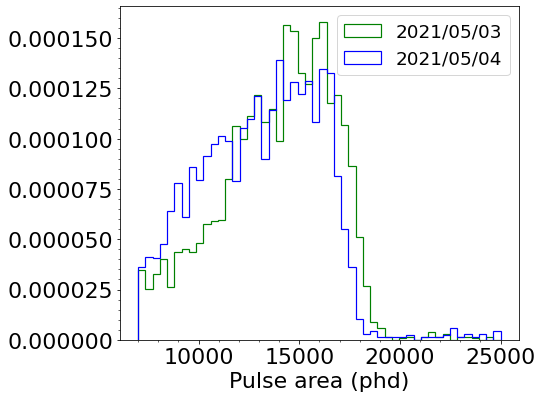

In [10]:
pl.figure()
#pl.yscale("log")
area_min_plot=7000
area_max_plot=25000
bin_n = 50

pl.hist((cleanArea), bins=bin_n,range=(area_min_plot,area_max_plot), label='2021/05/03', color = 'green', density=True, histtype = "step", linewidth=1.2)
#if np.mean(cleanArea)<area_max_plot: pl.axvline(x=np.mean(cleanArea), ls='--', color='g')
pl.hist((cleanArea_1), bins=bin_n,range=(area_min_plot,area_max_plot), label = '2021/05/04', color = 'blue', density=True, histtype = "step", linewidth=1.2)
#if np.mean(cleanArea_1)<area_max_plot: pl.axvline(x=np.mean(cleanArea_1), ls='--', color='b')
#pl.hist(cleanArea_2, bins=bin_n,range=(area_min_plot,area_max_plot), label = 'LXe after freeze', color = 'r', density=True, histtype = "step", linewidth=1.2)
pl.xlabel("Pulse area (phd)")
pl.minorticks_on()
pl.legend(loc=1)
plot_name = "S1s size with time"+' '+pulse_cut_name+".png"
pl.savefig(save_dir+plot_name)

with open(save_dir+'log.txt', 'a+') as f:
    f.write('\n'+plot_name+'\n')
    f.write(data_dir[data_dir.find('data-'):]+'\n')
    f.write(data_dir_1[data_dir.find('data-'):]+'\n')


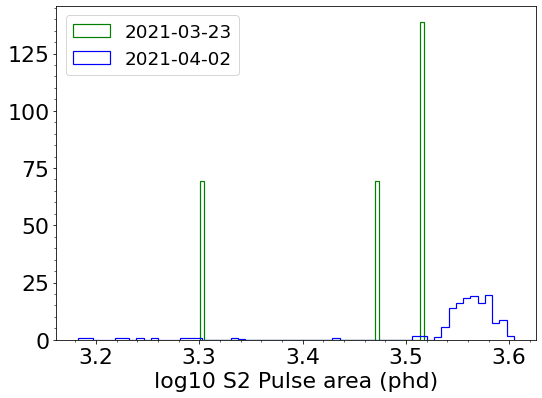

In [50]:
pl.figure()
bin_n = 60
pl.hist(np.log10(cleanS2Area), bins=bin_n,  label = '2021-03-23', color = 'green', density=True, histtype = "step", linewidth=1.2)
pl.hist(np.log10(cleanS2Area_1), bins=bin_n,  label = '2021-04-02', color = 'blue', density=True, histtype = "step", linewidth=1.2)
#pl.axvline(x=np.mean(cleanS1Area), ls='--', color='r')
pl.xlabel("log10 S2 Pulse area (phd)")
pl.minorticks_on()
pl.legend(loc = 2)
pl.savefig(save_dir+"Co S2 before and after freezing"+pulse_cut_name +".png")

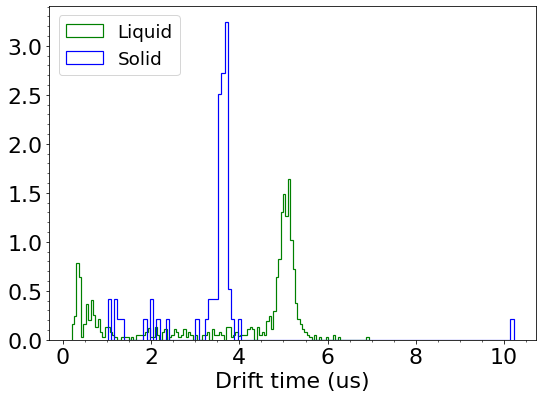

In [40]:
pl.figure()
pl.rcParams.update({'font.size': 22})
pl.hist(cleanDT, bins=125, label = 'Liquid', color = 'green', density=True, histtype = "step", linewidth=1.2)
pl.hist(cleanDT_1, bins=125, label = 'Solid', color = 'blue', density=True, histtype = "step", linewidth=1.2)
#pl.axvline(x=np.mean(cleanS1Area), ls='--', color='r')
pl.xlabel("Drift time (us)")
pl.legend(loc = 2)
pl.minorticks_on()
plot_name = "Po_drift_Time_April_S2_bigger_than_100"+".png"
pl.savefig(save_dir+plot_name)

with open(save_dir+'log.txt', 'a+') as f:
    f.write('\n'+plot_name+'\n')
    f.write(data_dir[data_dir.find('data-'):]+'\n')
    f.write(data_dir_1[data_dir.find('data-'):]+'\n')

In [ ]:
pl.figure()
pl.hist(cleanDT, bins=40, alpha=0.8, label = 'Liquid', color = 'green', density=True, histtype = "step")
pl.hist(cleanDT_1, bins=40, alpha=0.8, label = 'Solid', color = 'blue', density=True, histtype = "step")
pl.axvline(x=np.mean(cleanS1Area), ls='--', color='r')
pl.xlabel("S1 area (phd)")
pl.legend()
pl.savefig(save_dir+"S1_"+pulse_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(cleanS2Area, 500)
pl.axvline(x=np.mean(cleanS2Area), ls='--', color='r')
pl.xlabel("S2 area (phd)")
if save_S1S2_plots: pl.savefig(data_dir+"S2_"+pulse_cut_name +".png")

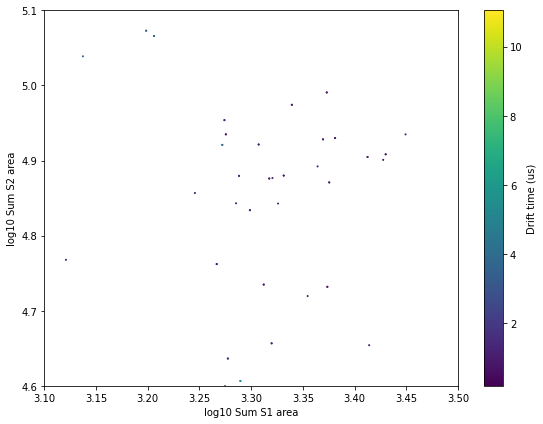

In [35]:
# Plots of event-level variables
pl.figure()
pl.scatter(np.log10(cleanSumS1), np.log10(cleanSumS2), s = 1, c=cleanDT)
pl.xlabel("log10 Sum S1 area")
pl.ylabel("log10 Sum S2 area")
pl.xlim(3.1, 3.5)
pl.ylim(4.6, 5.1)
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_vs_log10_SumS1_"+event_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanSumS1), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS1)), ls='--', color='r')
pl.xlabel("log10 Sum S1 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS1_"+event_cut_name +".png")

In [ ]:
pl.figure()
pl.hist(np.log10(cleanSumS2), 100)
pl.axvline(x=np.mean(np.log10(cleanSumS2)), ls='--', color='r')
pl.xlabel("log10 Sum S2 area (phd)")
if save_event_plots: pl.savefig(data_dir+"log10_SumS2_"+event_cut_name +".png")

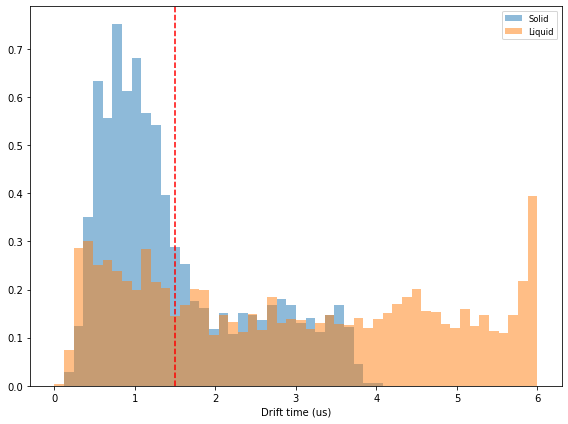

In [52]:
pl.figure() # Only ever plot this for SS events?
pl.hist(cleanDT, bins=50, range=(0,6), alpha=0.5, label = 'Solid', density=True)
pl.hist(cleanDT_1, bins=50, range=(0,6), alpha=0.5, label = 'Liquid', density=True)
pl.axvline(x=np.mean(cleanDT), ls='--', color='r')
pl.xlabel("Drift time (us)")
pl.legend()
if save_event_plots: pl.savefig(data_dir+"DriftTime_"+event_cut_name +".png")

In [ ]:
pl.figure() # Only ever plot this for SS events?
pl.scatter(cleanDT, cleanSumS2)
pl.xlabel("Drift time (us)")
pl.ylabel("Sum S2 area")
# Calculate mean vs drift bin
drift_bins=np.linspace(0,13,50)
drift_ind=np.digitize(cleanDT, bins=drift_bins)
s2_medians=np.zeros(np.shape(drift_bins))
s2_std_err=np.ones(np.shape(drift_bins))*0#10000
for i_bin in range(len(drift_bins)):
    found_i_bin = np.where(drift_ind==i_bin)
    s2_area_i_bin = cleanSumS2[found_i_bin]
    if len(s2_area_i_bin) < 1: continue
    s2_medians[i_bin]=np.median(s2_area_i_bin) # Median instead of mean, better at ignoring outliers
    s2_std_err[i_bin]=np.std(s2_area_i_bin)/np.sqrt(len(s2_area_i_bin))
pl.errorbar(drift_bins, s2_medians, yerr=s2_std_err, linewidth=3, elinewidth=3, capsize=5, capthick=4, color='red')
pl.ylim(bottom=0)
if save_event_plots: pl.savefig(data_dir+"SumS2_vs_DriftTime_"+event_cut_name +".png")

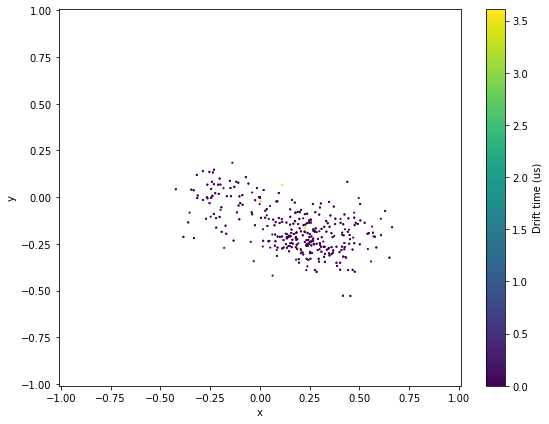

In [15]:
pl.figure()
pl.scatter(clean_center_top_x, clean_center_top_y, s = 1.2, c=clean_drift_time_four)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass on Top"+event_cut_name+".png")

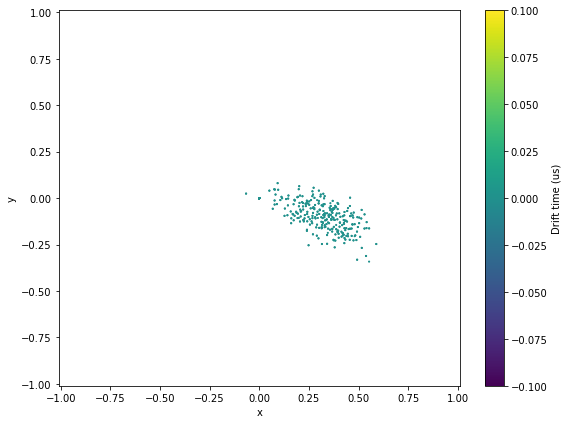

In [10]:
pl.figure()
pl.scatter(clean_center_bot_x, clean_center_bot_y, s = 1.2, c=clean_drift_time_four)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
cbar=pl.colorbar()
cbar.set_label("Drift time (us)")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass bottom"+event_cut_name+".png")

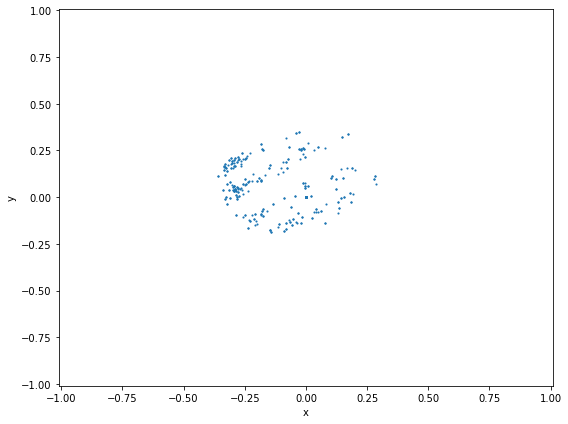

In [30]:
pl.figure()
pl.scatter(clean_center_bot_x, clean_center_bot_y, s = 1.2)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass bottom (no drift time)"+event_cut_name+".png")

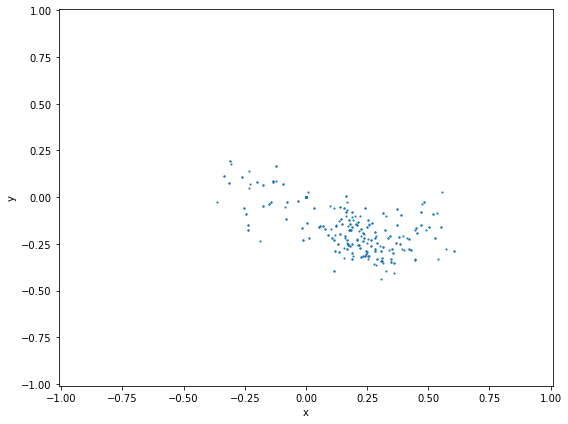

In [31]:
pl.figure()
pl.scatter(clean_center_top_x, clean_center_top_y, s = 1.2)
pl.xlim(-1.01,1.01)
pl.ylim(-1.01,1.01)
pl.ylabel("y")
pl.xlabel("x")
#pl.legend(handles=pc_legend_handles)
if save_pulse_plots: pl.savefig(data_dir+"Center of Mass on Top (no drift time) "+event_cut_name+".png")